# Classification and features

First, import necessary packages; if you do not have [``ipympl``](https://github.com/matplotlib/jupyter-matplotlib) installed, then you can replace ``%matplotlib widget`` with either ``%matplotlib notebook`` if you're running the old Jupyter notebook GUI, otherwise with ``%matplotlib inline`` (which does not allow interaction with plot figures, but should work universally).

In [1]:
# Replace "widget" with "inline" or "notebook", if necessary
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

from keras.utils import to_categorical
from keras.datasets import fashion_mnist

Using TensorFlow backend.


Then, load the dataset (if this is the first time you're doing this, you will need a network connection).

In [2]:
(x3_train, y_train), (x3_test, y_test) = fashion_mnist.load_data()
n_classes = np.max(y_train) + 1

# Vectorize image arrays, since most methods expect this format
x_train = x3_train.reshape(x3_train.shape[0], np.prod(x3_train.shape[1:]))
x_test = x3_test.reshape(x3_test.shape[0], np.prod(x3_test.shape[1:]))

# Binary vector representation of targets (for one-hot or multinomial output networks)
y3_train = to_categorical(y_train)
y3_test = to_categorical(y_test)

In [3]:
x3_train.shape

(60000, 28, 28)

In [5]:
x_train.shape

(60000, 784)

Next, we shall define some auxiliary functions for inspecting the image data.

In [5]:
def show_images(images, cols = 5, cmap=plt.cm.gray, im_shape=None, fig=None):
    """Display a set of images.
    
    images: Either a (N,K) or (N,K,L) array. If 2D, then each row will be reshaped to a rectangle.
    im_shape: If images is 2D, the shape of each image. If omitted, defaults to (sqrt(K),sqrt(K)).
    cols: Number of columns in subplots; rows is ceil(N/cols).
    cmap: Colormap to use."""
    if fig is None:
        fig = plt.figure()
    dims = images.shape
    if len(dims) not in (2,3):
        raise ValueError("images must be either 2D or 3D array")
    if len(dims) == 3:
        if im_shape is not None:
            raise ValueError("im_shape redundant when images is a 3D array")
        else:
            im_shape = dims[1:]
    if len(dims) == 2 and im_shape is None:
        L = int(np.sqrt(dims[1]))
        if L*L != dims[1]:
            raise ValueError("im_shape is missing and number of columns not a perfect square")
        im_shape = (L, L)
    N = dims[0]
    rows = (N + cols - 1)//cols
    for i in range(N):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(images[i,...].reshape(im_shape), cmap=cmap)
        

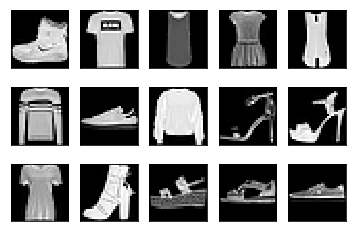

In [6]:
show_images(x3_train[0:15,...])

## 1. Logistic regression on raw images

First train a logistic regression model on the raw images, using ``scikit-learn``, and report training and test errors.  Make sure to explain any additional steps you needing to take, including (but not necessarily limited to):
- Target variable encoding (multinomial vs. one-hot)
- Optimizer and it's parameters
- Regularizer (e.g., none, $L_1$ or $L_2$) and its parameter(s)
- Any normalization you performed on feature values (e.g., centering, unit-variance)

In [6]:
## Your code ########
# TODO: Modify this code, as you deem necessary
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lr.fit(x_train, y_train)
print("Train score: %f" % lr.score(x_train, y_train))
print("Test score: %f" % lr.score(x_test, y_test))

/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Train score: 0.863200
Test score: 0.841200


Since iterations don't converge, we consider normalization to accelarate the convergence.

In [15]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)     
x_test_scaled = scaler.fit_transform(x_test) 

/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Train a logistic regression model after normalization. The iterations don't converge either but both train and test scores improve a little.

In [8]:
lr2 = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lr2.fit(x_train_scaled, y_train)
print("Train score: %f" % lr2.score(x_train_scaled, y_train))
print("Test score: %f" % lr2.score(x_test_scaled, y_test))

Train score: 0.876617
Test score: 0.843400


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Using one-hot encoding for target variable, the performance is worse than multinomial encoding. In addition, it takes much more time using one-hot encoding, so we choose multinomial encoding.

In [57]:
lr3 = LogisticRegression(solver='lbfgs',multi_class='ovr')
lr3.fit(x_train_scaled, y_train)
print("Train score: %f" % lr3.score(x_train_scaled, y_train))
print("Test score: %f" % lr3.score(x_test_scaled, y_test))

/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number 

Train score: 0.875150
Test score: 0.839600


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Change the optimizer and compare the performance. Test scores are higher for 'sag' and 'saga' optimizers.

In [65]:
lr5 = LogisticRegression(solver='sag', multi_class='multinomial')
lr5.fit(x_train_scaled, y_train)
print("Train score: %f" % lr5.score(x_train_scaled, y_train))
print("Test score: %f" % lr5.score(x_test_scaled, y_test))

Train score: 0.872150
Test score: 0.845600


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [66]:
lr6 = LogisticRegression(solver='saga', multi_class='multinomial')
lr6.fit(x_train_scaled, y_train)
print("Train score: %f" % lr6.score(x_train_scaled, y_train))
print("Test score: %f" % lr6.score(x_test_scaled, y_test))

Train score: 0.869000
Test score: 0.845800


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Study different norms of regularization. The default penalty is L2. Since the 'newton-cg', 'sag' and 'lbfgs' solvers support only l2 penalties. We consider L1 penalty with 'sage' solver. The train score is higer yet the test score is lower. It shows that the penalty parameter C is not small enough.

In [68]:
lr7 = LogisticRegression(solver='saga', multi_class='multinomial',penalty='l1')
lr7.fit(x_train_scaled, y_train)
print("Train score: %f" % lr7.score(x_train_scaled, y_train))
print("Test score: %f" % lr7.score(x_test_scaled, y_test))

/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train score: 0.871800
Test score: 0.845200


Study the influence of penalty parameters. First for L2 penalties,

In [52]:
train_score=[]
test_score=[]
for c in np.arange(0.01,1,0.05):
    lr8 = LogisticRegression(solver='lbfgs', multi_class='multinomial',C=c)
    lr8.fit(x_train_scaled, y_train)
    train_score=np.append(train_score,lr8.score(x_train_scaled,y_train))
    test_score=np.append(test_score,lr8.score(x_test_scaled,y_test))

/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number 

The performance doesn't change that much.

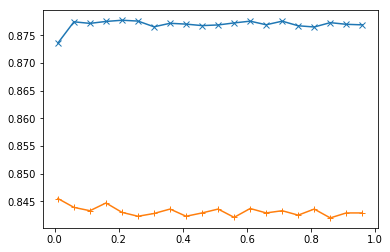

In [53]:
x=np.arange(0.01,1,0.05)
plt.plot(x,train_score,'x-',label='train score')
plt.plot(x,test_score,'+-',label='test score')
plt.show()

Visualize the model coefficients for each of the ten classes as an image (you can use ``show_images`` defined above); is there an intuitive interpretation?  Include this in your remarks below.

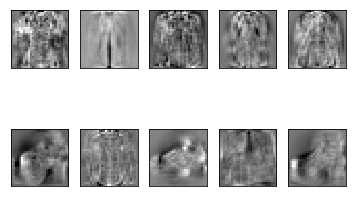

In [9]:
## Your code ########
# TODO: Modify this code, as you deem necessary (and don't forget to comment below)
show_images(lr.coef_)

---

### Your remarks/discussion on "straight" logistic regression (see questions above):

**TODO**: Edit cell to add your comments
1. Target variable encoding: multinomial encoding performs better in this case.
2. Optimizer and it's parameters: Both 'sag' and 'sage' optimizers perform slightly better than 'lbfgs' optimizer in terms of test scores.
3. Regularizer (e.g., none, $L_1$ or $L_2$) and its parameter(s): Using 'sage' optimizer, the train score with L2 regularizer is 0.869000 while the test score is 0.845800. For L1 regularizer with the same optimizer, the train score is 0.871800 yet the test score is 0.845200. Consequently, L2 performs better in terms of avoiding overfitting.
4. Any normalization you performed on feature values: normalization will improve the performance.
---

Use ten-fold cross-validation to select a good $L_1$-norm regularization strength. You may want to look at
``sklearn.linear_model.LogisticRegressionCV`` as well as Scikit-Learn's [overview of cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

In [69]:
## Your code ########
# TODO: Add your code here
from sklearn.linear_model import LogisticRegressionCV
lrcv = LogisticRegressionCV(cv = 10, penalty = 'l1', solver = 'saga', multi_class = 'multinomial',max_iter=80,n_jobs = 2)
lrcv.fit(x_train_scaled,y_train)

/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_ite

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=80,
           multi_class='multinomial', n_jobs=2, penalty='l1',
           random_state=None, refit=True, scoring=None, solver='saga',
           tol=0.0001, verbose=0)

In [110]:
lrcv.C_

array([0.35938137, 0.35938137, 0.35938137, 0.35938137, 0.35938137,
       0.35938137, 0.35938137, 0.35938137, 0.35938137, 0.35938137])

In [98]:
lrcv.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [125]:
lrcv.scores_[0][:,4].mean()

0.85755

Plot the cross-validation scores against parameter value, using a [box plot](https://matplotlib.org/gallery/statistics/boxplot_demo.html). We can see that the model performs the best when C=0.359. The best average accuracy is 0.85755.

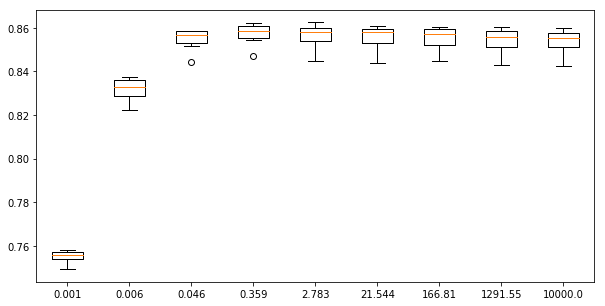

In [118]:
## Your code ########
# TODO: Add your code here
plt.figure(figsize=(10,5))
plt.boxplot(lrcv.scores_[0][:,1:], labels = np.around(lrcv.Cs_[1:], decimals=3), sym = "o")
plt.xlabel=("C")
plt.ylabel=('cross validation scroe')
plt.show()

Finally, train a neural network that performs multi-class logistic regression, and compare it's performance against the Scikit-learn model.  Try to get it to perform as close to the Scikit-learn model as possible.

In addition to describing briefly what you did, and discussing performance, do not forget to also explain your output encoding as well as the corresponding choice of activation function and loss function.

In [23]:
from keras import regularizers
n_output = y3_train.shape[1]
n_input = x_train_scaled.shape[1]

nn_lr = Sequential() 
nn_lr.add(Dense(units=n_output, input_dim= n_input, activation = 'softmax',
          kernel_regularizer = regularizers.l1(0.005),bias_regularizer = regularizers.l1(0.005)))
nn_lr.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
h = nn_lr.fit(x_train_scaled, y3_train, epochs = 100, batch_size = 100, validation_data = (x_test_scaled, y3_test),verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 88us/step - loss: 1.9126 - acc: 0.7690 - val_loss: 1.3975 - val_acc: 0.8032
Epoch 2/100
60000/60000 [==============================] - 3s 46us/step - loss: 1.1283 - acc: 0.8201 - val_loss: 0.9900 - val_acc: 0.8127
Epoch 3/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.9135 - acc: 0.8201 - val_loss: 0.9047 - val_acc: 0.8119
Epoch 4/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.8704 - acc: 0.8190 - val_loss: 0.8834 - val_acc: 0.8130
Epoch 5/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.8562 - acc: 0.8192 - val_loss: 0.8727 - val_acc: 0.8099
Epoch 6/100
60000/60000 [==============================] - 3s 58us/step - loss: 0.8483 - acc: 0.8195 - val_loss: 0.8683 - val_acc: 0.8117
Epoch 7/100
60000/60000 [==============================] - 3s 49us/step - loss: 0.8435 - acc: 0.8200 - val_loss: 0.8630 - 

In [24]:
print("Train score: %f" % nn_lr.evaluate(x_train_scaled, y3_train,verbose=0)[1])
print("Test score: %f" % nn_lr.evaluate(x_test_scaled, y3_test,verbose=0)[1])

Train score: 0.822517
Test score: 0.815300


Just as you did for the Scikit-learn logistic model, visualize the coefficients (aka. weights) for each class as an image, and include possible interpretation in your comments below.

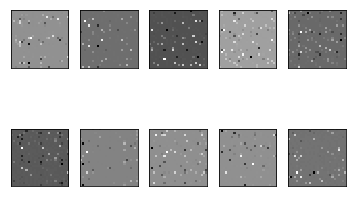

In [25]:
## Your code ########
# TODO: Add your code here (and comment below)
show_images(nn_lr.get_weights()[0].reshape(n_output, n_input));

Finally, repeat the training process at least ten times (starting with a fresh model and a different random seed each time) and plot the performance (accuracy) of your trained model using a boxplot.

In [26]:
## Your code ########
# TODO: Add your code here
train_score = []
test_score = []
nn_val = Sequential() 
nn_val.add(Dense(n_output, input_dim = n_input, activation = 'softmax',
          kernel_regularizer = regularizers.l1(.005),bias_regularizer = regularizers.l1(.005)))
nn_val.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
for _ in range(10):
    nn_val.fit(x_train_scaled, y3_train, epochs = 100, batch_size = 100, validation_data = (x_test_scaled, y3_test), shuffle = True, verbose = 0)
    train_score.append(nn_val.evaluate(x_train_scaled, y3_train)[1])
    test_score.append(nn_val.evaluate(x_test_scaled, y3_test)[1])

10000/10000 [==============================] - 0s 40us/step


In [33]:
train_score

[0.8227333333333333,
 0.8221333333333334,
 0.8229333333333333,
 0.8223,
 0.8239,
 0.8207666666666666,
 0.8213166666666667,
 0.8232666666666667,
 0.8229333333333333,
 0.823]

In [32]:
test_score

[0.815, 0.8142, 0.8153, 0.8141, 0.8146, 0.8133, 0.8108, 0.8145, 0.8147, 0.8146]

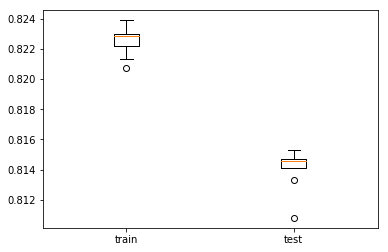

In [31]:
fig = plt.figure()
ax = plt.subplot() 
ax.boxplot([train_score,test_score],labels=['train','test'],sym = "o")
plt.show()

---

### Your remarks on logistic network performance, output encoding, and activation/loss functions

**TODO**: Edit cell and add your comments

I firstly trained a one-layer net with softmax as activation function and categorical_crossentropy as loss function. The regularizer parameter equals to 0.005 and The output encoder is one-hot encoding. Both train and test scores are worse than direct logistic regression. After training ten times, the average train score is 0.823 and the average test score is 0.815. In addition, the coefficient images are less informative than logistic regression.

---

## 2. Feature extraction via PCA and ICA

Perform principal component analysis (PCA) on the image data; you can use the Scikit-learn ``PCA`` class (already imported above).  If you use ``np.svd`` instead, make sure you normalize your data matrix appropriately.

In [58]:
## Your code ########
# TODO: Add your code here
pca = PCA()
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test)

Next, display the top-20 principal components (i.e., eigenvectors of covariance matrix) as images (you can use ``show_images`` defined above), and discuss what they represent, qualitatively.

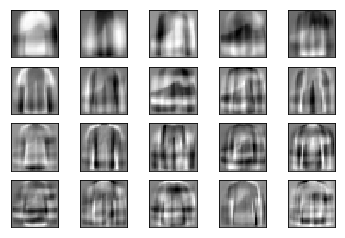

In [42]:
## Your code ########
# TODO: Add your code here
#x_train_reduce = pca.inverse_transform(x_train_pca)
show_images(pca.components_[0:20])

---

### Your remarks/discussion of principal components:

**TODO**: Edit cell and add you comments
We can see PCA gives components that project the original dataset to a low-dimension plane. The first principal componet gives the outline of a T-shirt. The second one gives the outline of shoes and so on so forth. The following components give more detailed features that differenciate each class.

---

Next, display the [Scree plot](https://en.wikipedia.org/wiki/Scree_plot).  What is the fraction of the variance explained by the top-20 components?

In [45]:
np.sum(pca.explained_variance_ratio_[0:20]) # 78.49% of variance is explained by the top-20 components

0.7848589759410002

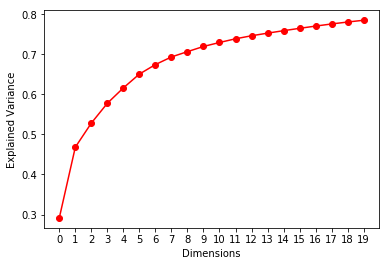

In [59]:
## Your code ########
# TODO: Add your code here 
plt.ylabel('Explained Variance')
plt.xlabel('Dimensions')
plt.plot( np.cumsum(pca.explained_variance_ratio_[0:20]),'r-o')
plt.xticks(np.arange(0,20,1))
plt.show()

Next, perform independent component analysis (ICA) on the image data; you can use the Scikit-learn ``FastICA`` class (already imported above).  Note that you may need to limit the number of components, depending on how long estimation takes on your machine.

In [53]:
## Your code ########
# TODO: Add your code here
ica = FastICA(random_state=0,n_components=20)
x_train_ica = ica.fit_transform(x_train)
x_test_ica = ica.fit_transform(x_test)

Again, plot the top-20 independent components as images (you can use ``show_images`` defined above), and discuss what they represent qualitatively.

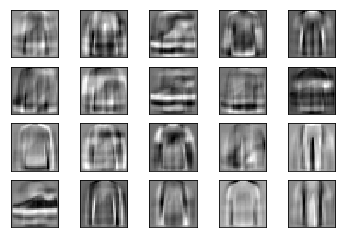

In [54]:
## Your code ########
# TODO: Add your code here
show_images(ica.components_[0:20])

---

### Your remarks/discusssion of independent components:

**TODO**: Edit cell and add your comments

ICA decompose the original data into independent components, so each component carriesmore information than that of PCA. Ass we can see, the first principal componen contains information of both T-shirts and shoes.

---

## 3. Logistic regression on PCA and ICA features

Train a logistic regression on the top-$K$ principal component features and examine it's training and test error.  Does it perform better or worse than the model on the straight features? Why? Also, justify your choice of $K$.

First, check the relationship between K and accumulated explained variance. We can see that the explained variance increases slower when K>15 so we select several values of K from 15 to 50.

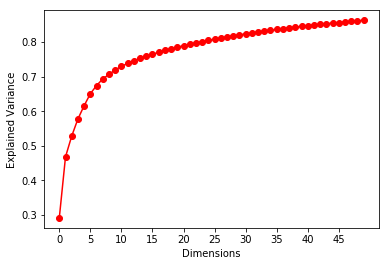

In [69]:
plt.ylabel('Explained Variance')
plt.xlabel('Dimensions')
plt.plot( np.cumsum(pca.explained_variance_ratio_[0:50]),'r-o')
plt.xticks(np.arange(0,50,5))
plt.show()

In [7]:
## Your code ########
# TODO: Add your code here
lr_pca = LogisticRegression(solver='lbfgs', multi_class = 'multinomial')
K = [15, 20, 25, 30, 35, 40, 45, 50]
pca_train_score = []
pca_test_score = []
for k in K:
    pca_k = PCA(n_components = k)
    x_train_pca = pca_k.fit_transform(x_train)
    x_test_pca = pca_k.fit_transform(x_test)
    lr_pca.fit(x_train_pca, y_train)
    pca_train_score.append(lr_pca.score(x_train_pca, y_train))
    pca_test_score.append(lr_pca.score(x_test_pca, y_test))

/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number 

Visualize the performance with different values of K.

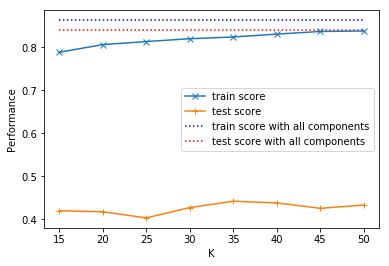

In [14]:
plt.plot(K, pca_train_score,'x-', label = 'train score')
plt.ylabel('Performance')
plt.xlabel('K')
plt.plot(K, pca_test_score,'+-', label = 'test score')
plt.hlines(y = 0.863200, xmin = 15, xmax =50, color = 'b', linestyle = 'dotted', label = 'train score with all components')
plt.hlines(y = 0.841200, xmin = 15, xmax =50, color = 'r', linestyle = 'dotted', label = 'test score with all components')
plt.legend(loc='center right')
plt.show()

---

### Your remarks on PCA-based logistic regression performance (accuracy and training speed) and choice of $K$:

**TODO**: Edit cell and add your comments.

We can see that the train performance increases with larger values of K but the test performance decreases when K>35. So we suggest to choose K=35. In addition, the train performance of PCA is close to the original model but the test performance is much worse.

---

Next, do the same on the top-$K$ independent component features, and answer the same questions.

In [17]:
## Your code ########
# TODO: Add your code here
lr_ica = LogisticRegression(solver='lbfgs', multi_class = 'multinomial')
K = [15, 20, 25, 30, 35, 40, 45, 50]
ica_train_score = []
ica_test_score = []
for k in K:
    ica_k = FastICA(n_components = k, random_state=0)
    x_train_ica = ica_k.fit_transform(x_train)
    x_test_ica = ica_k.fit_transform(x_test)
    lr_ica.fit(x_train_ica, y_train)
    ica_train_score.append(lr_ica.score(x_train_ica, y_train))
    ica_test_score.append(lr_ica.score(x_test_ica, y_test))

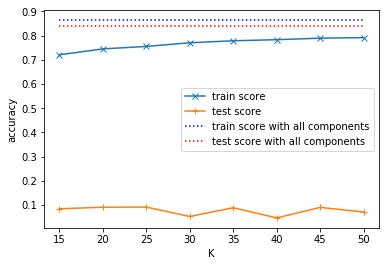

In [19]:
plt.plot(K, ica_train_score,'x-', label = 'train score')
plt.ylabel('accuracy')
plt.xlabel('K')
plt.plot(K, ica_test_score,'+-', label = 'test score')
plt.hlines(y = 0.863200, xmin = 15, xmax =50, color = 'b', linestyle = 'dotted', label = 'train score with all components')
plt.hlines(y = 0.841200, xmin = 15, xmax =50, color = 'r', linestyle = 'dotted', label = 'test score with all components')
plt.legend(loc='center right')
plt.show()

---

### Your remarks on ICA-based logistic regression performance and choice of $K$:

**TODO**: Edit cell and add your comments.

We can see that the train performance increases with larger values of K but the test performance decreases when K>25. So we suggest to choose K=25. In addition, the performance of ICA-based logistic regression model is worse than PCA-based.


---

## 4. Two-layer perceptron

Train a two-layer perceptron with $K$ hidden units.  Use the same output layer structure as you used for your logistic regression network before.  Evaluate it's performance, and don't forget to explain your hidden layer activations.

In [34]:
## Your code ########
# TODO: Add your code here
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Compare three different hidden layer activations: relu, sigmoid and tanh.

In [36]:
n_input = x_train.shape[1]
fig = plt.figure()
activations = ['relu', 'sigmoid', 'tanh']
for index, activation in enumerate(activations):
    K_hidden = Sequential()
    K_hidden.add(Dense(512, activation = activation, input_dim = n_input ))
    K_hidden.add(Dense(10,activation = 'softmax',
          kernel_regularizer = regularizers.l1(0.005),bias_regularizer = regularizers.l1(.005)))
    K_hidden.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history_k = K_hidden.fit(x_train_scaled, y3_train, epochs = 20, batch_size = 100, validation_data = (x_test_scaled, y3_test), shuffle = True, verbose = 0)
    print("train score : %f (%s)" % (K_hidden.evaluate(x_train_scaled, y3_train)[1], activation))
    print("test score : %f (%s)" % (K_hidden.evaluate(x_test_scaled, y3_test)[1], activation))

60000/60000 [==============================] - 4s 67us/step
train score : 0.866417 (relu)
10000/10000 [==============================] - 1s 68us/step
test score : 0.848200 (relu)
60000/60000 [==============================] - 6s 94us/step
train score : 0.823950 (sigmoid)
10000/10000 [==============================] - 1s 94us/step
test score : 0.813900 (sigmoid)
60000/60000 [==============================] - 6s 100us/step
train score : 0.867583 (tanh)
10000/10000 [==============================] - 1s 90us/step
test score : 0.848000 (tanh)


<Figure size 432x288 with 0 Axes>

Using the tanh as activation function, compare different degrees of dropout:

In [37]:
d = [0.2, 0.4, 0.6, 0.8]
for index, degree in enumerate(d):
    K_hidden_d = Sequential()
    K_hidden_d.add(Dense(512, activation = 'tanh', input_dim = n_input))
    K_hidden_d.add(Dropout(degree))
    K_hidden_d.add(Dense(10,activation = 'softmax',
          kernel_regularizer = regularizers.l1(0.005),bias_regularizer = regularizers.l1(0.005)))
    K_hidden_d.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history_d = K_hidden_d.fit(x_train_scaled, y3_train, epochs = 20, batch_size = 100, validation_data = (x_test_scaled, y3_test), shuffle = True, verbose = 0)
    print("train score : %f (%s)" % (K_hidden_d.evaluate(x_train_scaled, y3_train)[1], degree))
    print("test score : %f (%s)" % (K_hidden_d.evaluate(x_test_scaled, y3_test)[1], degree))

60000/60000 [==============================] - 4s 74us/step
train score : 0.864967 (0.2)
10000/10000 [==============================] - 1s 78us/step
test score : 0.844900 (0.2)
60000/60000 [==============================] - 6s 101us/step
train score : 0.859650 (0.4)
10000/10000 [==============================] - 1s 105us/step
test score : 0.842600 (0.4)
60000/60000 [==============================] - 6s 106us/step
train score : 0.856450 (0.6)
10000/10000 [==============================] - 1s 113us/step
test score : 0.840600 (0.6)
60000/60000 [==============================] - 6s 102us/step
train score : 0.846767 (0.8)
10000/10000 [==============================] - 1s 106us/step
test score : 0.833600 (0.8)


Using the tanh as activation function, compare different numbers of hidden unites:

In [38]:
K = [64, 128, 256, 512, 1000]
for index, units in enumerate(K):
    K_hidden_K = Sequential()
    K_hidden_K.add(Dense(units = units, activation = 'tanh', input_dim = n_input))
    K_hidden_K.add(Dropout(0.2))
    K_hidden_K.add(Dense(10, activation = 'softmax',
          kernel_regularizer = regularizers.l1(0.005),bias_regularizer = regularizers.l1(.005)))
    K_hidden_K.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history_K = K_hidden_K.fit(x_train_scaled, y3_train, epochs = 20, batch_size = 100, validation_data = (x_test_scaled, y3_test), shuffle = True, verbose = 0)
    print("train score : %f (%s)" % (K_hidden_K.evaluate(x_train_scaled, y3_train)[1], units))
    print("test score : %f (%s)" % (K_hidden_K.evaluate(x_test_scaled, y3_test)[1], units))

60000/60000 [==============================] - 3s 57us/step
train score : 0.865883 (64)
10000/10000 [==============================] - 1s 58us/step
test score : 0.845500 (64)
60000/60000 [==============================] - 3s 57us/step
train score : 0.865117 (128)
10000/10000 [==============================] - 0s 46us/step
test score : 0.845300 (128)
60000/60000 [==============================] - 5s 82us/step
train score : 0.864417 (256)
10000/10000 [==============================] - 1s 95us/step
test score : 0.845300 (256)
60000/60000 [==============================] - 6s 105us/step
train score : 0.864800 (512)
10000/10000 [==============================] - 1s 97us/step
test score : 0.844900 (512)
60000/60000 [==============================] - 7s 121us/step
train score : 0.863033 (1000)
10000/10000 [==============================] - 1s 124us/step
test score : 0.845200 (1000)


### Also, plot the hidden layer weights as images (you can use ``show_images`` again), and discuss what they might qualitatively represent.

In [39]:
## Your code ########
# TODO: Add your code here
hidden = Sequential()
hidden.add(Dense(units = 64, activation = 'tanh', input_dim = n_input ))
hidden.add(Dropout(0.2))
hidden.add(Dense(10, activation = 'softmax',kernel_regularizer = regularizers.l1(0.005),bias_regularizer = regularizers.l1(.005)))
hidden.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
h_K = hidden.fit(x_train_scaled, y3_train, epochs = 20, batch_size = 100, validation_data = (x_test_scaled, y3_test), shuffle = True, verbose = 0)
print("train score : %f" % hidden.evaluate(x_train_scaled, y3_train)[1])
print("test score : %f" % hidden.evaluate(x_test_scaled, y3_test)[1])

60000/60000 [==============================] - 3s 49us/step
train score : 0.868850
10000/10000 [==============================] - 0s 48us/step
test score : 0.849600


In [129]:
hidden.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 64)                50240     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


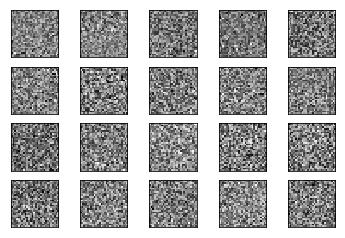

In [127]:
show_images(hidden.layers[0].get_weights()[0].reshape(64,784)[0:20,...])

---

### Your remarks on 2LP, choice of $K$, hidden activations, and interpretation of hidden weights

**TODO**: Edit cell and add your comments.

I study the performance of 2LP on different choices of $K$, hidden activations and degrees of dropout and find that the model performs best when K=64, activation='tanh' and degree=0.2. The visualization of hidden weights doesn't show much information in terms of image classes.

---

Furthermore, is it possible to choose activation and loss functions in such a way that the network model performs PCA followed by logistic regression, or something similar?  Would it be identical, or not?  Briefly justify your answer.  Even if it is possible, is it desirable?  Why or why not?

---

### Your remarks on 2LP for PCA + logistic regression

**TODO**: Edit cell and add your comments.

It is possible to train network followed by PCA. It will speed up the training process since less inputs are learned. But the performance may be worse because low-variance informaiton may be lost by using PCA. So it wouldn't be identical and it is not desirable if we have enough computation resources.

---

## 5. Convolutional networks

Design a convolutional network for the classification task at hand.  Your aim should be to achieve the best prediction performance you can, given available resources.

In [44]:
## Your code ########
# TODO: Add your code here
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
X3_train = x3_train.reshape(60000, img_rows, img_cols, 1)
X3_test = x3_test.reshape(10000, img_rows, img_cols, 1)
X3_train = X3_train.astype('float32')
X3_test = X3_test.astype('float32')
X3_train/= 255
X3_test/= 255

In [49]:
import keras
batch_size = 256
n_classes = 10
epochs = 50

#input image dimensions
img_rows, img_cols = 28, 28

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, (3, 3), activation='relu'))
cnn.add(Dropout(0.4))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(n_classes, activation='softmax'))

cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [50]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 128)         73856     
__________

In [55]:
h = cnn.fit(X3_train, y3_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X3_test, y3_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 92s 2ms/step - loss: 0.8340 - acc: 0.6910 - val_loss: 0.5130 - val_acc: 0.8083
Epoch 2/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.5009 - acc: 0.8149 - val_loss: 0.4140 - val_acc: 0.8518
Epoch 3/50
60000/60000 [==============================] - 113s 2ms/step - loss: 0.4199 - acc: 0.8463 - val_loss: 0.3498 - val_acc: 0.8737
Epoch 4/50
60000/60000 [==============================] - 133s 2ms/step - loss: 0.3767 - acc: 0.8617 - val_loss: 0.3222 - val_acc: 0.8830
Epoch 5/50
60000/60000 [==============================] - 144s 2ms/step - loss: 0.3486 - acc: 0.8714 - val_loss: 0.3069 - val_acc: 0.8885
Epoch 6/50
60000/60000 [==============================] - 144s 2ms/step - loss: 0.3284 - acc: 0.8791 - val_loss: 0.2837 - val_acc: 0.8969
Epoch 7/50
60000/60000 [==============================] - 133s 2ms/step - loss: 0.3139 - acc: 0.8842 - val_loss: 0.2796 - va

In [58]:
print("train score : %f" % cnn.evaluate(X3_train, y3_train)[1])
print("test score : %f" % cnn.evaluate(X3_test, y3_test)[1])

60000/60000 [==============================] - 31s 512us/step
train score : 0.960567
10000/10000 [==============================] - 5s 494us/step
test score : 0.919500


Plot the convolution kernels of your first convolutional layer as images.

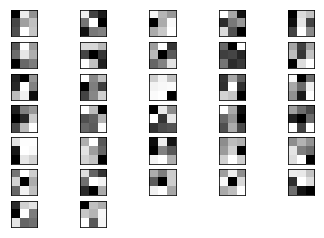

In [59]:
## Your code ########
# TODO: Add your code here
show_images(cnn.layers[0].get_weights()[0].reshape(32,3,3))

In [65]:
cnn.layers[0].get_weights()[0].shape

(3, 3, 1, 32)

Choose one data point from each class, and plot the first layer convolution outputs (again, as images) for each of them.  For convenience, you can use the first occurence of each class, as given by the code below.

In [66]:
# Find the indices of the first occurence of each class within the training set
repr_index = np.zeros(n_classes, dtype=np.int)
for c in range(n_classes):
    repr_index[c] = np.argwhere(y_train == c)[0,0]

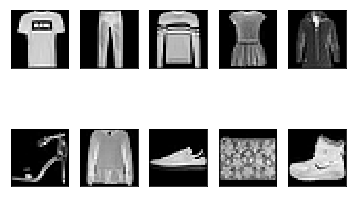

In [131]:
## Your code ########
# TODO: Add your code here; note that it must create 10 *separate* plots, one after the other
show_images(X3_train[repr_index,].reshape(10,28,28));

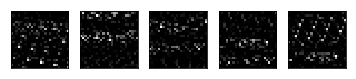

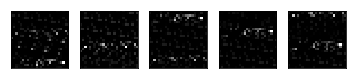

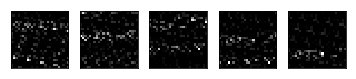

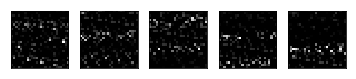

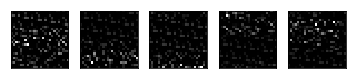

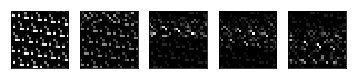

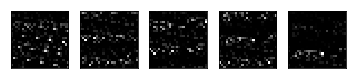

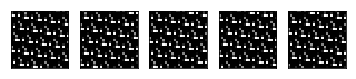

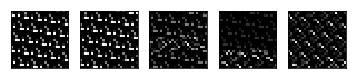

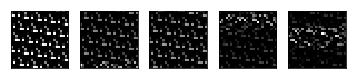

In [149]:
from keras import models
model = models.Model(inputs=cnn.input, outputs=cnn.layers[0].output)
output = model.predict(X3_train[repr_index])
for index, data in enumerate(output):
    data = data.reshape(32,26,26)
    show_images(data[0:5]);

---

### Your discussion of possible qualitative interpretation of the convolution kernels

**TODO**: Edit cell and add your comments

I build three convolution layers with 32, 64 and 128 nodes and one full-connected layer with 128 nodes. The first two convolution layers are followed by two maxpooling layers respectively. Each layer is followed by a dropout layer. I use relu as activation function for every layer expect for the output layer with softmax function. The network is optimised by Adam.

The visulized kernels of the first layer show filtered images. The outputs of the first layer indicate differnt features for different image classes. The train score is 0.960567 and the test score is 0.919500. I'd like to add stronger regularizer in the further study to reduce overfitting.

---

# Submitting your work

Edit all the code and markdown cells marked with "TODO" and add your answers.  Please leave the horizontal rules (``---``) in markdown cells as well as the first comment (``## Your code ########``) in code cells, to make it easier to locate your answers.

### Please upload your ``.ipynb`` notebook file, **as well as a ``.pdf`` printout of it**.
This allows us to read your answers from *within* Canvas (``pdf``) as well as, if necessary, download and rerun parts of your code (``ipynb``).